# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Verificación inicial
print(data.info())
print(data.head())

# Verificar orden del índice
print("Índice monótono:", data.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
Índice monótono: True


In [5]:
# Remuestreo por hora
data = data.resample('1H').sum()
print(data.head())

# Verificación de datos faltantes
print(data.isna().sum())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
num_orders    0
dtype: int64


## Análisis

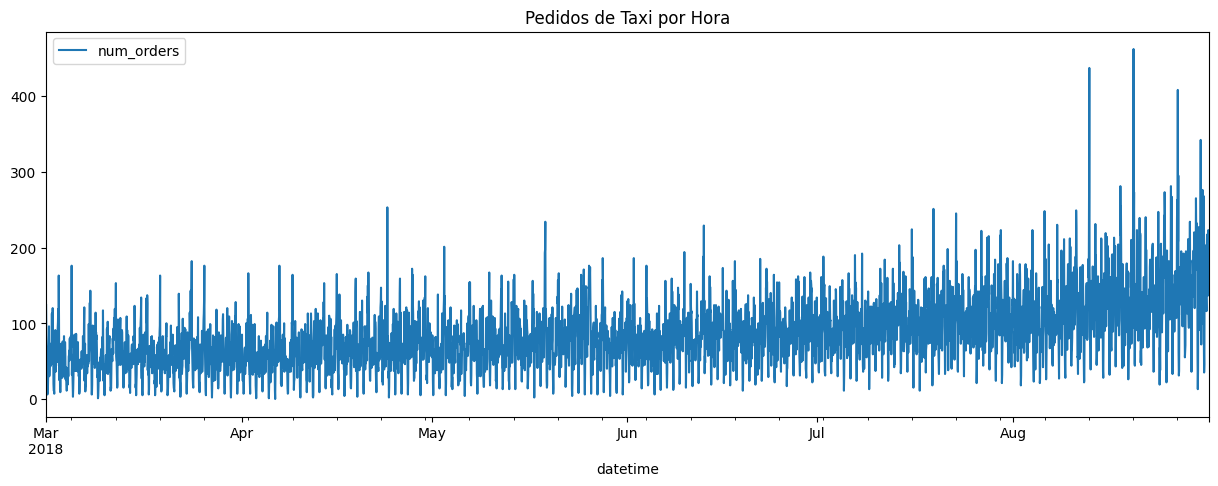

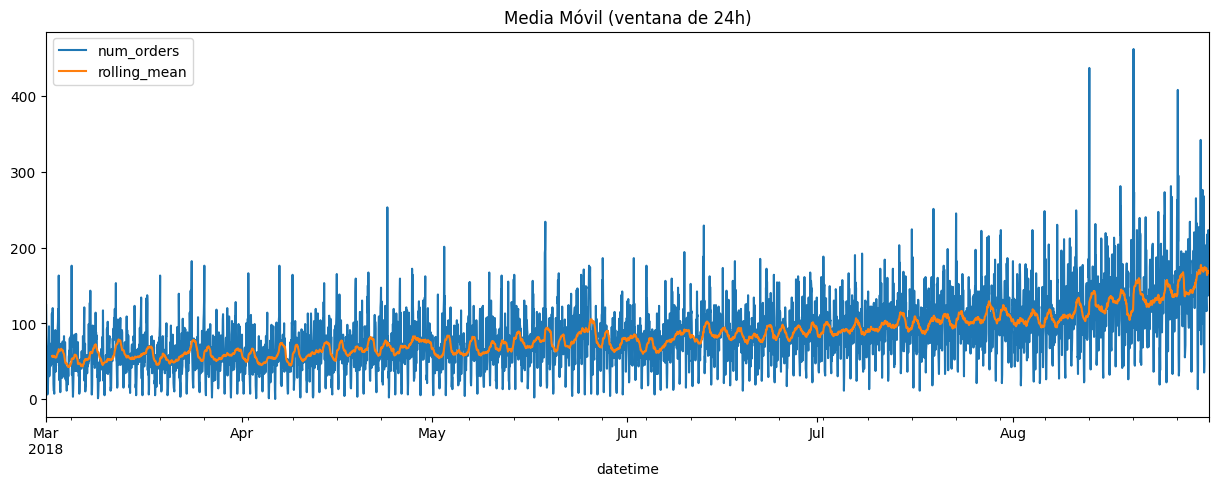

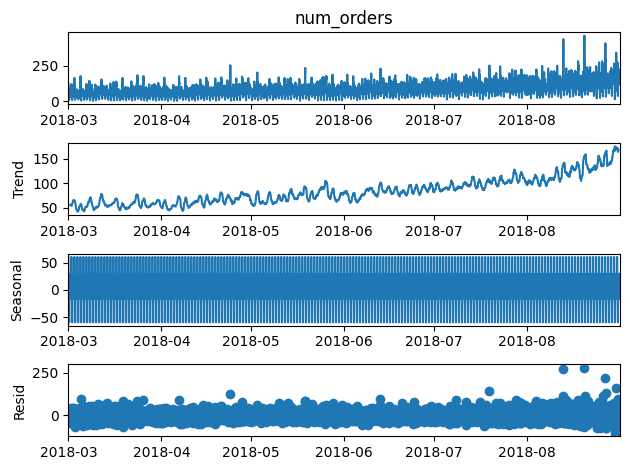

In [6]:
import matplotlib.pyplot as plt

# Gráfico general
data.plot(figsize=(15, 5), title="Pedidos de Taxi por Hora")

# Media móvil para detectar tendencias
data['rolling_mean'] = data['num_orders'].rolling(24).mean()
data[['num_orders', 'rolling_mean']].plot(figsize=(15, 5), title="Media Móvil (ventana de 24h)")

# Descomposición
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data['num_orders'])
decomposed.plot()
plt.show()

## Formación

In [7]:
# Crear variables de calendario
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Crear variables de desfase (lags)
data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)

# Media móvil: promedio de los últimos 3 valores anteriores (sin incluir el actual)
data['rolling_mean'] = data['num_orders'].shift(1).rolling(window=3).mean()

# Eliminar filas con valores faltantes generados por lag y rolling
data = data.dropna()

In [8]:
from sklearn.model_selection import train_test_split

# Separar características y variable objetivo
features = data.drop(columns='num_orders')
target = data['num_orders']

# División temporal (sin mezclar): 90% entrenamiento, 10% prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

# Verificar tamaños
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)

Tamaño entrenamiento: (3971, 6)
Tamaño prueba: (442, 6)


In [9]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Función para evaluar modelos
def evaluar_modelo(modelo, nombre):
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    recm = sqrt(mean_squared_error(y_test, predicciones))
    print(f"{nombre} - RECM: {recm:.2f}")
    return modelo, predicciones

# Entrenar y evaluar modelos
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
}

resultados = {}
for nombre, modelo in modelos.items():
    entrenado, pred = evaluar_modelo(modelo, nombre)
    resultados[nombre] = (entrenado, pred)

Regresión Lineal - RECM: 56.58
Random Forest - RECM: 53.86
Gradient Boosting - RECM: 55.00


## Prueba

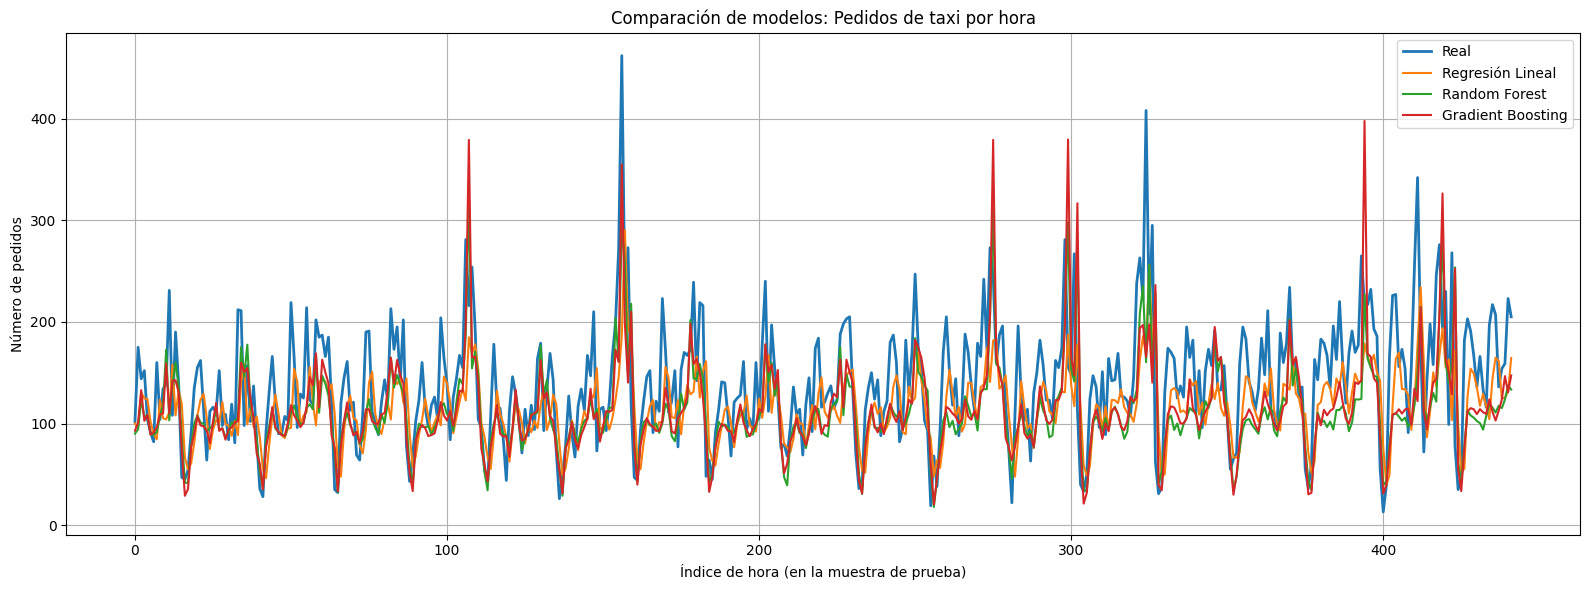

In [11]:
# Visualizar predicciones vs valores reales para todos los modelos
plt.figure(figsize=(16, 6))
plt.plot(y_test.values, label='Real', linewidth=2)

for nombre, (modelo, pred) in resultados.items():
    plt.plot(pred, label=nombre)

plt.title("Comparación de modelos: Pedidos de taxi por hora")
plt.xlabel("Índice de hora (en la muestra de prueba)")
plt.ylabel("Número de pedidos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusión

Se entrenaron tres modelos diferentes para predecir la demanda horaria de taxis:

- **Regresión Lineal**: RECM = 56.58
- **Random Forest**: RECM = 53.86
- **Gradient Boosting**: RECM = 55.00

Aunque **ninguno de los modelos cumple aún con el umbral de RECM ≤ 48 exigido por el proyecto**, el modelo de **Random Forest** es el que mejor desempeño presenta, siendo una buena base para optimización futura.

En resumen, ya se construyó una primera versión funcional del modelo y se identificaron oportunidades claras de mejora para cumplir con la métrica objetivo.